# Bootstrap (Resampling)

#### TL; DR
To develop a deeper understanding of bootstrapping as a method/process to lower bias and variance simultaneously by combining several models trained over varying subsets

**"Model Averaging"**

- with "replacement"

### Parameter Estimation

Mean:

$$E(\bar{\theta}_B)= E\big\{\frac{1}{B}\sum_{i=1}^B\hat{\theta}_{i}\big\}=\theta$$

Variance (more complicated):

Given $\varrho=corr(\hat{\theta}_{i},\hat{\theta}_{j}),\ var(\hat{\theta}_{i})=\sigma^2$

Then 

$$var(\theta_{B})=\frac{1-\varrho}{B}\sigma^2 + \varrho\sigma^2$$

where $\varrho$ is the correlation between 2 estimates (reality)

### Confidence Interval

- bootstrapping used in CI's: 

$$95\% \ CI \approx \hat{\theta}_{B} \pm 1.96 std(\hat{\theta})$$


### Definition of Variance

$$var(\bar{\theta}_{B})=E\big\{(\frac{1}{B}S+{B}-\mu)^2\big\}$$

$$var(\bar{\theta}_{B})=\frac{1}{B^2}E\big\{(S_{B}-\mu B)^2\big\}$$

$$var(\bar{\theta}_{B})=\frac{1}{B^2}E\big\{S_{B}^2-2\mu BS_{B}+\mu^2B^2\big\}$$

$$var(\bar{\theta}_{B})=\frac{1}{B^2}\big[E\{S_{B}^2\}-\mu^2 B^2\big]$$

$$var(\bar{\theta}_{B})=\frac{1}{B^2}E\{S_{B}^2\}-\mu^2$$

which leads to

$$var(\theta_{B})=\frac{1-\varrho}{B}\sigma^2 + \varrho\sigma^2$$

### Takeaway:

If $\varrho = 1$ or close to 1 then you don't get any improvement in variance but if $\varrho=0$ perfect non-correlation the variance decreases by $\frac{1}{B}$

- In general not a great improvement for linear models but in highly nonlinear models like decision trees (non-correlated)

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import norm, t

In [8]:
B = 200
N = 20
X = np.random.randn(N)

print(f"sample mean: {X.mean()}")

sample mean: 0.010971190275399837


In [12]:
sample_estimates = np.empty(B)

for b in range(B):
    temp_sample = np.random.choice(X, size=N)
    sample_estimates[b] = temp_sample.mean()

In [14]:
bmean = sample_estimates.mean()
bstd = sample_estimates.std()

lower = bmean + norm.ppf(0.025)*bstd
upper = bmean + norm.ppf(0.975)*bstd

print(bmean, bstd, lower, upper)

0.0033261348176939287 0.20706611418290946 -0.40251599139946714 0.409168261034855


In [16]:
# traditional way of calculating CI
lower_old = X.mean() + norm.ppf(0.025)*X.std()/np.sqrt(N)
upper_old = X.mean() + norm.ppf(0.975)*X.std()/np.sqrt(N)

print(lower_old, upper_old)

-0.38566520708809515 0.40760758763889476


# Bagging

#### Bagging = bootstrap aggregating 

Exactly like bagging but instead of estimating $\hat{\theta} we train/fit a model.

*Regression is simply averaging the output but classification is more difficult with the voting process*

### Regressor

Using a DecisionTreeClassifier

score for 1 tree: 0.9777269607907193


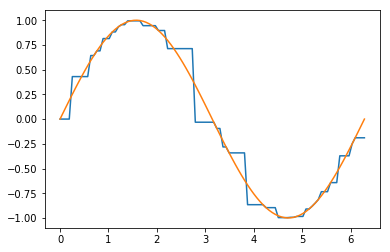

In [17]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.utils import shuffle


# create the data
T = 100
x_axis = np.linspace(0, 2*np.pi, T)
y_axis = np.sin(x_axis)

# get the training data
N = 30
idx = np.random.choice(T, size=N, replace=False) # random sample
Xtrain = x_axis[idx].reshape(N, 1)
Ytrain = y_axis[idx]

# try a lone decision tree
model = DecisionTreeRegressor()
model.fit(Xtrain, Ytrain)
prediction = model.predict(x_axis.reshape(T, 1))
print("score for 1 tree:", model.score(x_axis.reshape(T, 1), y_axis))

# plot the lone decision tree's predictions
plt.plot(x_axis, prediction)
plt.plot(x_axis, y_axis)
plt.show()

In [21]:
# now try bagging
class BaggedTreeRegressor:
  def __init__(self, B):
    self.B = B

  def fit(self, X, Y):
    N = len(X)
    self.models = []
    for b in range(self.B):
      idx = np.random.choice(N, size=N, replace=True)
      Xb = X[idx]
      Yb = Y[idx]

      model = DecisionTreeRegressor()
      model.fit(Xb, Yb)
      self.models.append(model)

  def predict(self, X):
    predictions = np.zeros(len(X))
    for model in self.models:
      predictions += model.predict(X)
    return predictions / self.B

  def score(self, X, Y):
    d1 = Y - self.predict(X)
    d2 = Y - Y.mean()
    return 1 - d1.dot(d1) / d2.dot(d2)

In [22]:
model = BaggedTreeRegressor(200)
model.fit(Xtrain, Ytrain)
print("score for bagged tree:", model.score(x_axis.reshape(T, 1), y_axis))
prediction = model.predict(x_axis.reshape(T, 1))

score for bagged tree: 0.9849860035814548


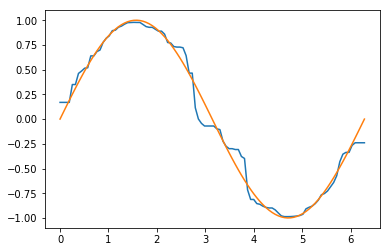

In [23]:
# plot the bagged regressor's predictions
plt.plot(x_axis, prediction)
plt.plot(x_axis, y_axis)
plt.show()

### Classifier

Using DecisionTreeClassifier

In [24]:
from sklearn.tree import DecisionTreeClassifier

In [26]:
def plot_decision_boundary(X, model):
  h = .02  # step size in the mesh
  # create a mesh to plot in
  x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
  y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
  xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                       np.arange(y_min, y_max, h))


  # Plot the decision boundary. For that, we will assign a color to each
  # point in the mesh [x_min, m_max]x[y_min, y_max].
  Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

  # Put the result into a color plot
  Z = Z.reshape(xx.shape)
  plt.contour(xx, yy, Z, cmap=plt.cm.Paired)

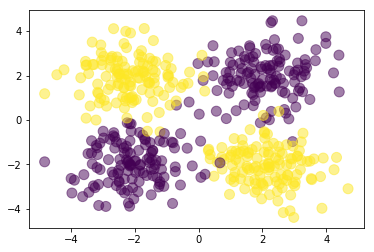

score for 1 tree: 1.0


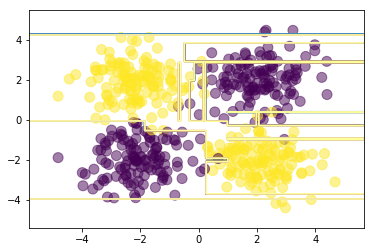

In [27]:
np.random.seed(10)

# create the data
N = 500
D = 2
X = np.random.randn(N, D)

# 2 gaussians
# sep = 1.5
# X[:N/2] += np.array([sep, sep])
# X[N/2:] += np.array([-sep, -sep])
# Y = np.array([0]*(N/2) + [1]*(N/2))

# noisy XOR
sep = 2
X[:125] += np.array([sep, sep])
X[125:250] += np.array([sep, -sep])
X[250:375] += np.array([-sep, -sep])
X[375:] += np.array([-sep, sep])
Y = np.array([0]*125 + [1]*125 + [0]*125 + [1]*125)

# plot the data
plt.scatter(X[:,0], X[:,1], s=100, c=Y, alpha=0.5)
plt.show()

# lone decision tree
model = DecisionTreeClassifier()
model.fit(X, Y)
print("score for 1 tree:", model.score(X, Y))

# plot data with boundary
plt.scatter(X[:,0], X[:,1], s=100, c=Y, alpha=0.5)
plot_decision_boundary(X, model)
plt.show()

In [29]:
# create the bagged model
class BaggedTreeClassifier:
  def __init__(self, B):
    self.B = B

  def fit(self, X, Y):
    N = len(X)
    self.models = []
    for b in range(self.B):
      idx = np.random.choice(N, size=N, replace=True)
      Xb = X[idx]
      Yb = Y[idx]

      model = DecisionTreeClassifier(max_depth=2)
      model.fit(Xb, Yb)
      self.models.append(model)

  def predict(self, X):
    # no need to keep a dictionary since we are doing binary classification
    predictions = np.zeros(len(X))
    for model in self.models:
      predictions += model.predict(X)
    return np.round(predictions / self.B)

  def score(self, X, Y):
    P = self.predict(X)
    return np.mean(Y == P)

score for bagged model: 0.918


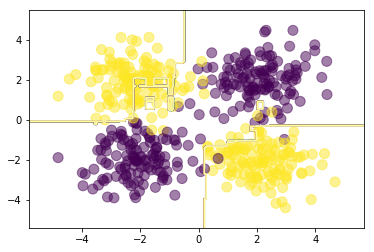

In [32]:
model = BaggedTreeClassifier(300)
model.fit(X, Y)

print("score for bagged model:", model.score(X, Y))

# plot data with boundary
plt.scatter(X[:,0], X[:,1], s=100, c=Y, alpha=0.5)
plot_decision_boundary(X, model)
plt.show()

In [54]:
B_ls = list(range(20, 300, 30))
score_arr = np.zeros(len(B_ls))

for idx, m in enumerate(B_ls):
    model = BaggedTreeClassifier(m)
    model.fit(X, Y)
    score_arr[idx] = model.score(X, Y)
    

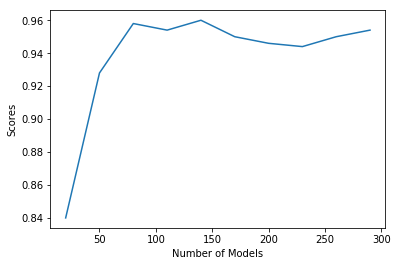

In [59]:
plt.plot(B_ls, score_arr)
plt.xlabel(f'Number of Models')
plt.ylabel(f'Scores')
plt.show()